## Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Podcast Listening Time Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Files
train.csv - the training dataset; Listening_Time_minutes is the target <br>
test.csv - the test dataset; your objective is to predict the Listening_Time_minutes for each row <br>
sample_submission.csv - a sample submission file in the correct format.

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 54.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 1.8 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle as pk
import warnings
warnings.simplefilter(action='ignore',category=Warning)
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [4]:
train = pd.read_csv(r'/kaggle/input/playground-series-s5e4/train.csv')

In [5]:
submission = pd.read_csv(r'/kaggle/input/playground-series-s5e4/sample_submission.csv')

In [6]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [7]:
train.drop(columns='id',axis=1,inplace=True)

In [8]:
train.columns

Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre',
       'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time',
       'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment',
       'Listening_Time_minutes'],
      dtype='object')

## Test Dataset Manipulation

In [9]:
test_df = pd.read_csv(r'/kaggle/input/playground-series-s5e4/test.csv')

In [10]:
test_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [11]:
test = test_df.drop(columns='id',axis=1)

In [12]:
test.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [13]:
test.columns

Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre',
       'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time',
       'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'],
      dtype='object')

In [14]:
print("Training Data Shape is ",train.shape)
print("Testing Data Shape is ",test.shape)

Training Data Shape is  (750000, 11)
Testing Data Shape is  (250000, 10)


### Exploratory Data Analysis

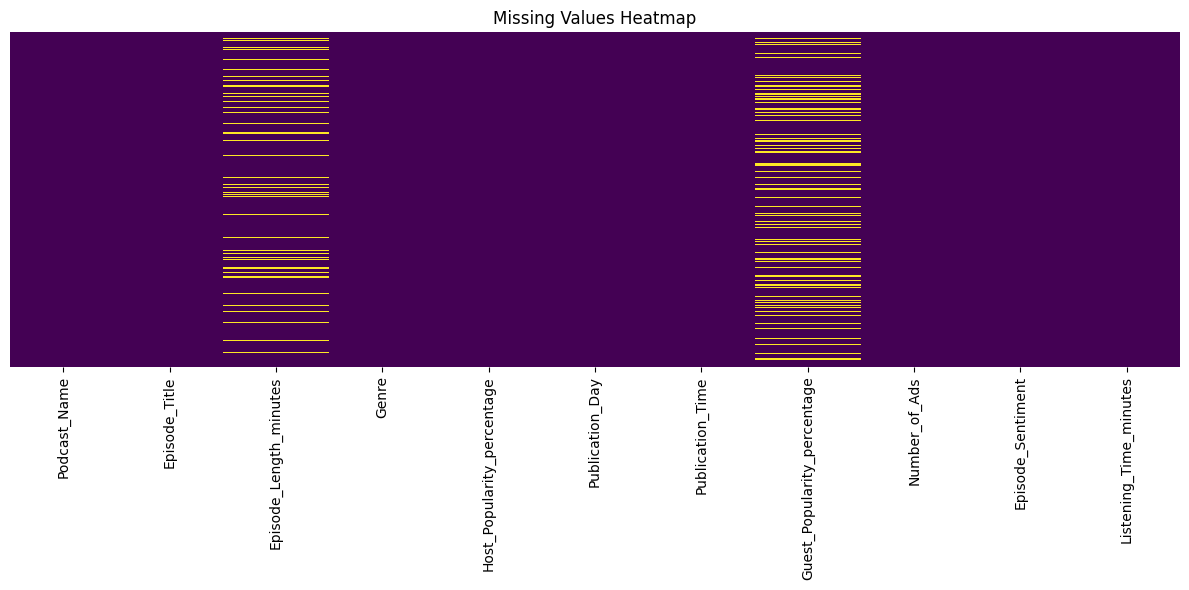

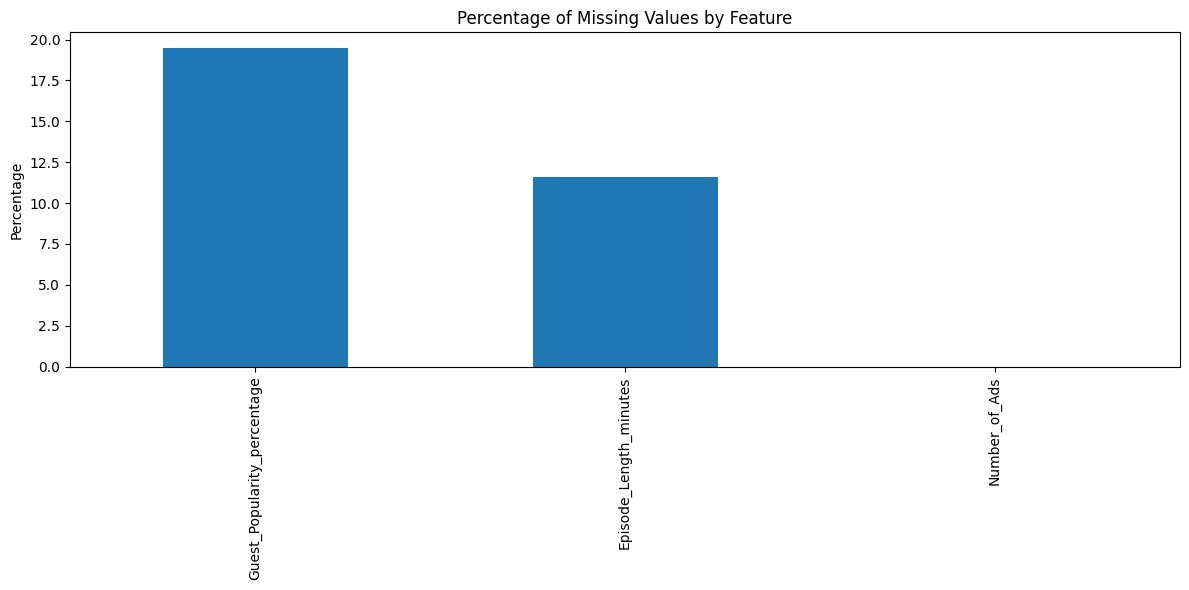

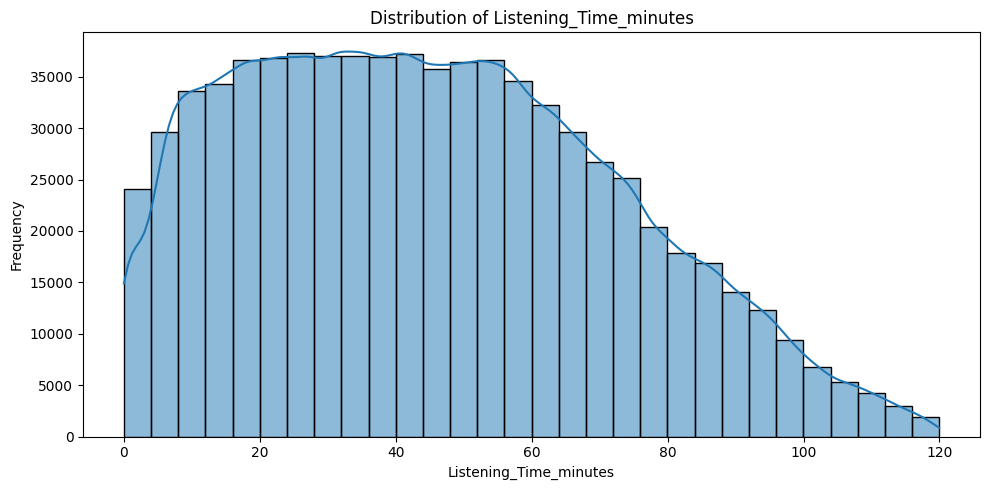

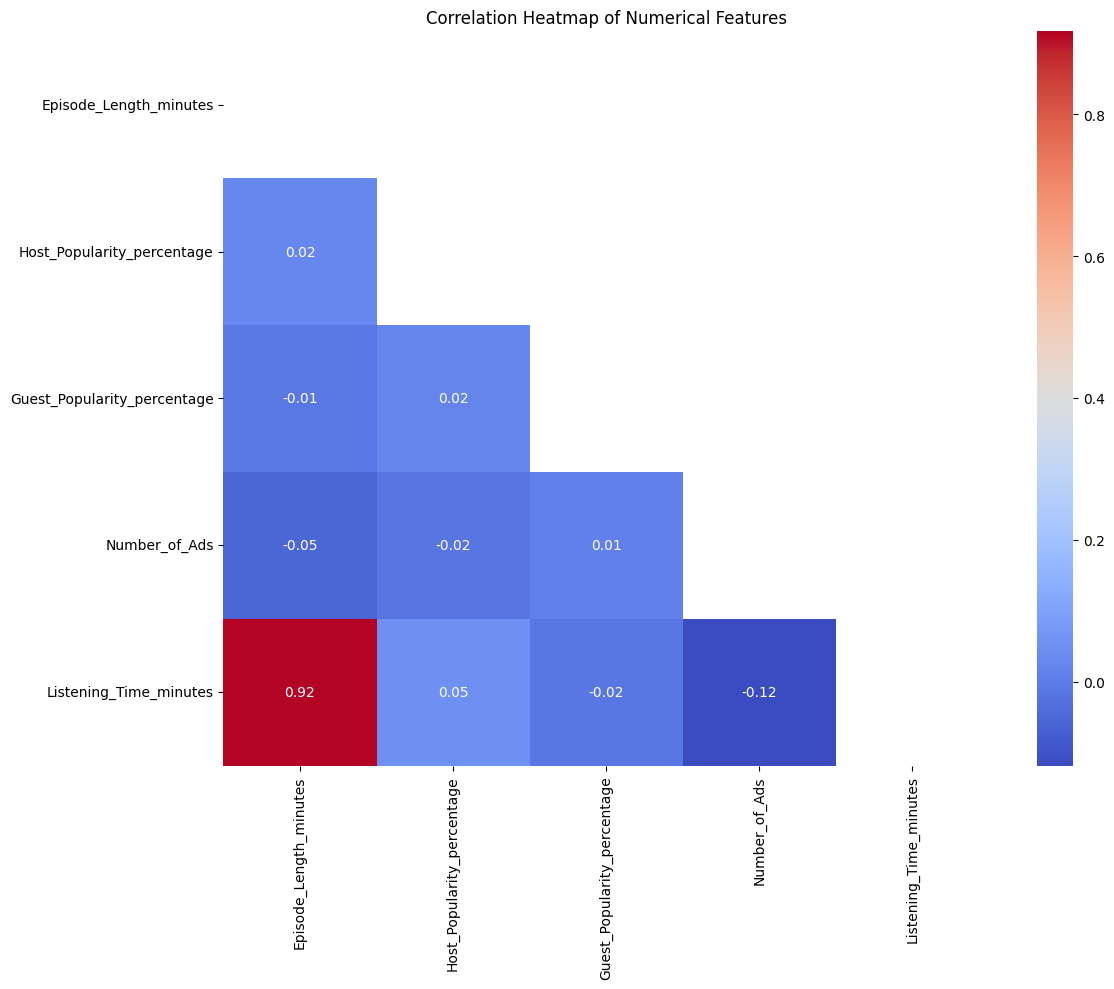

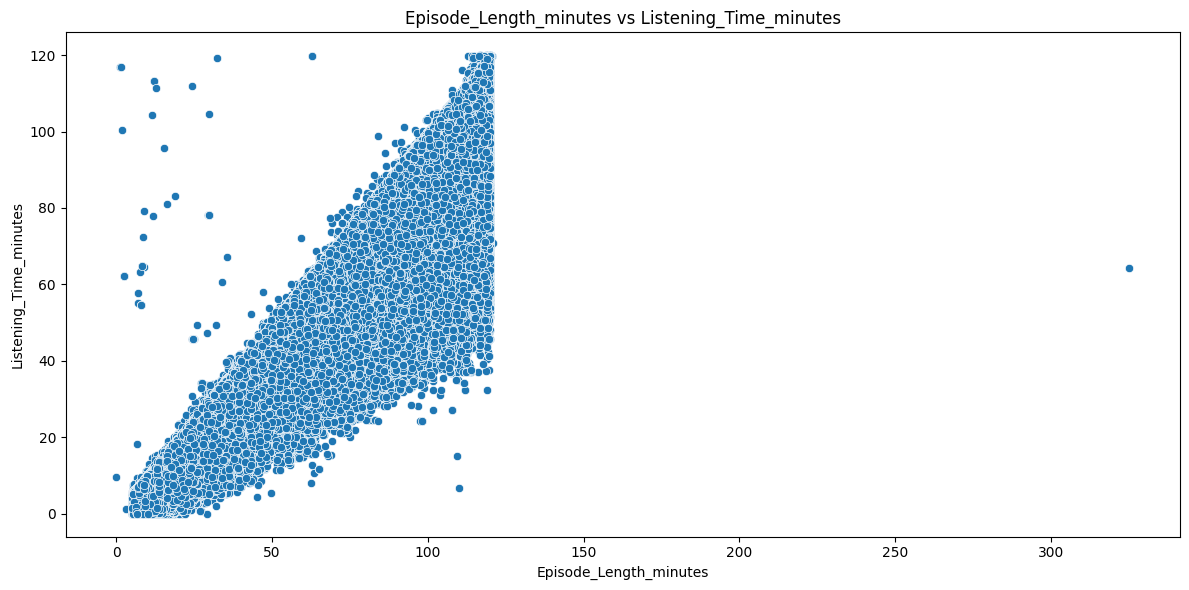

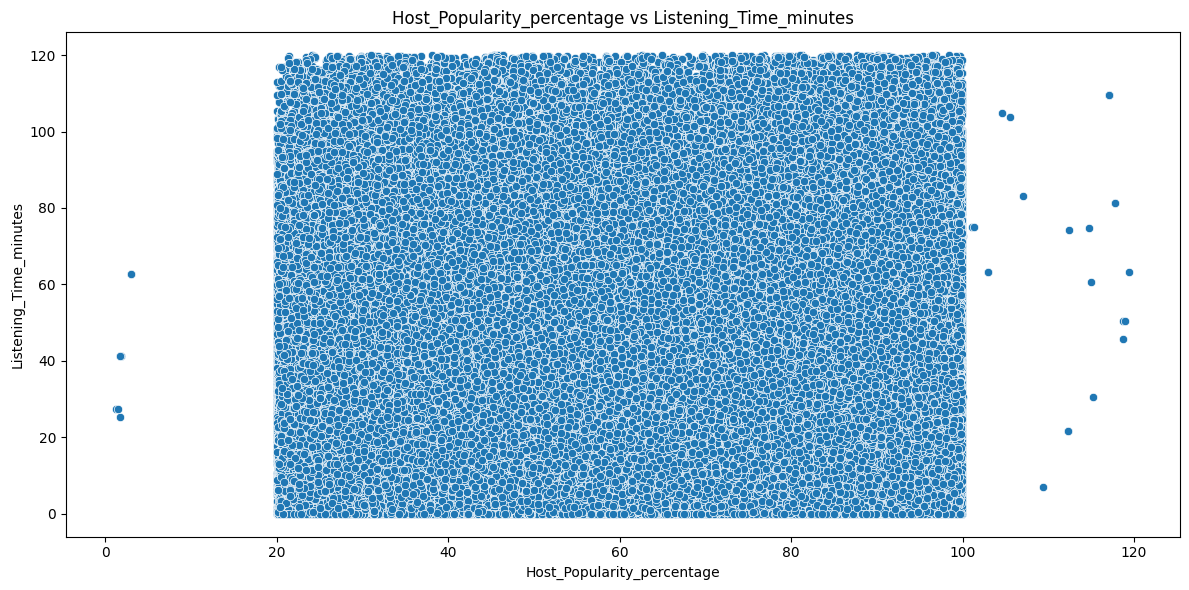

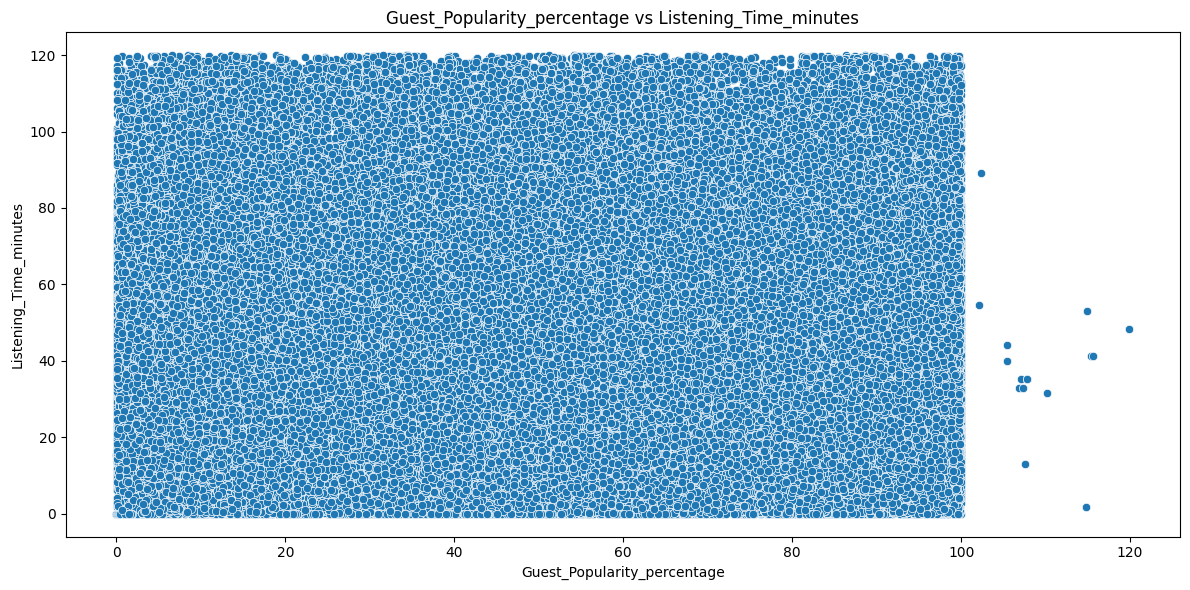

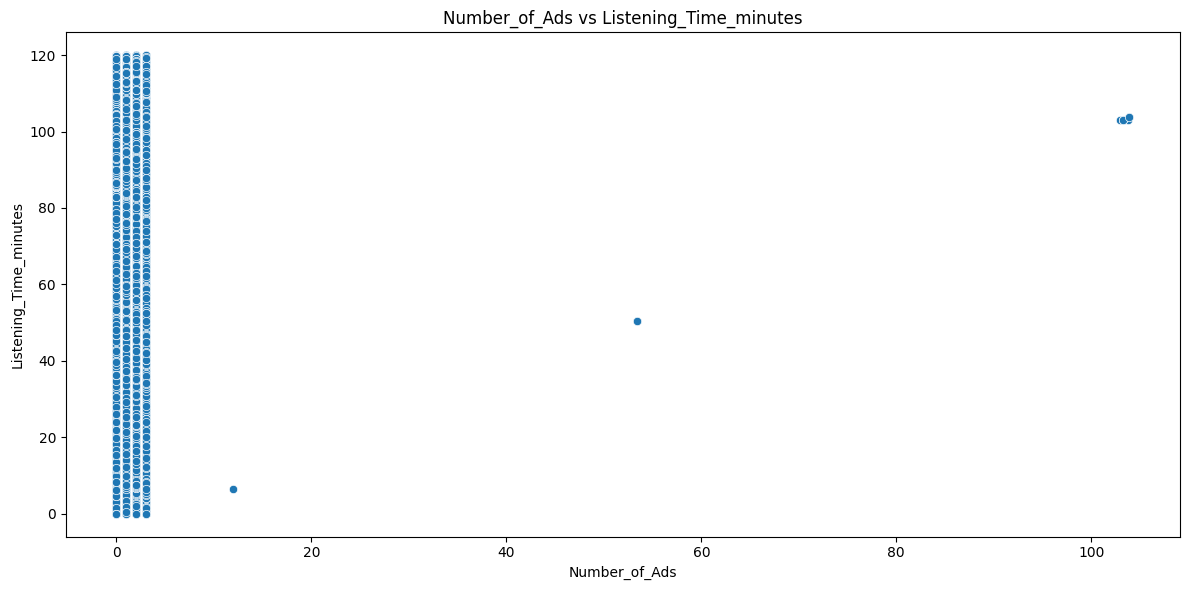

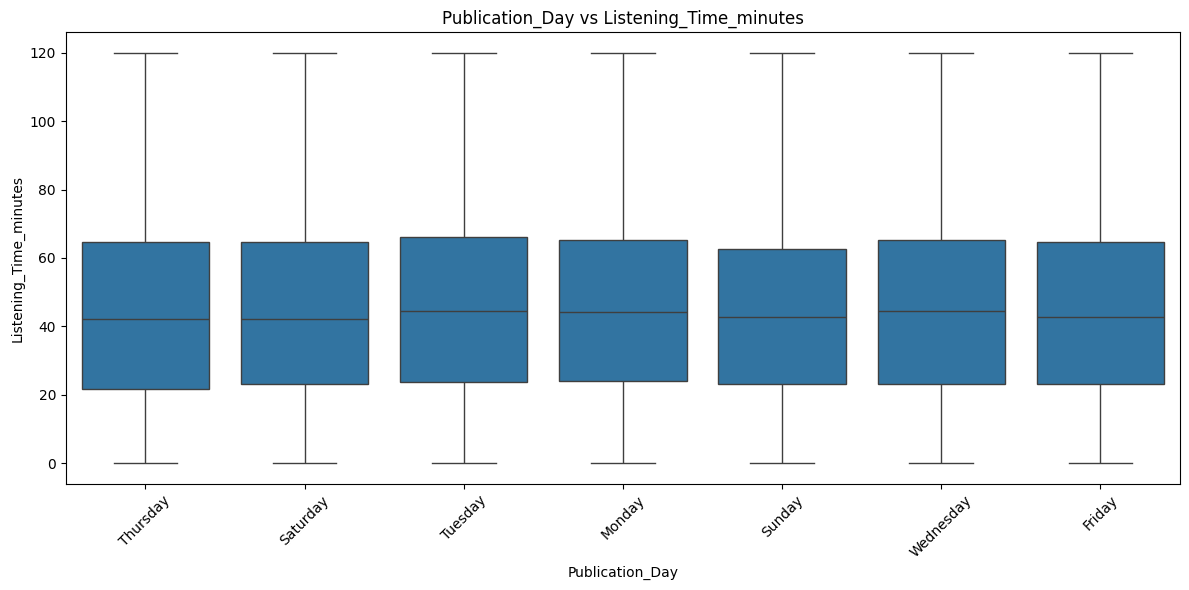

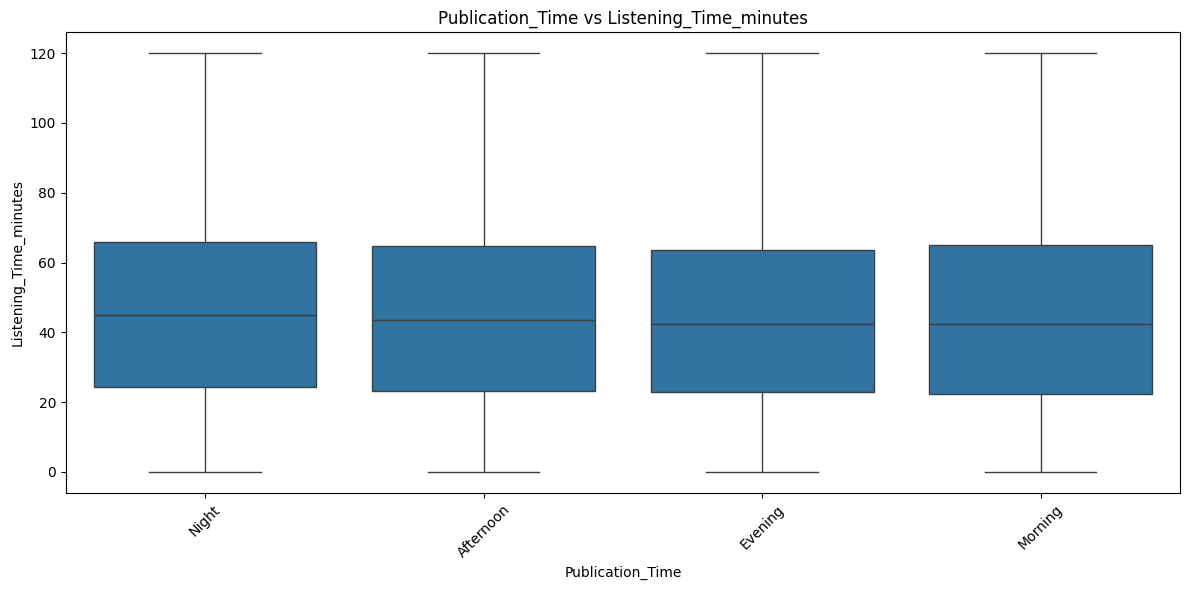

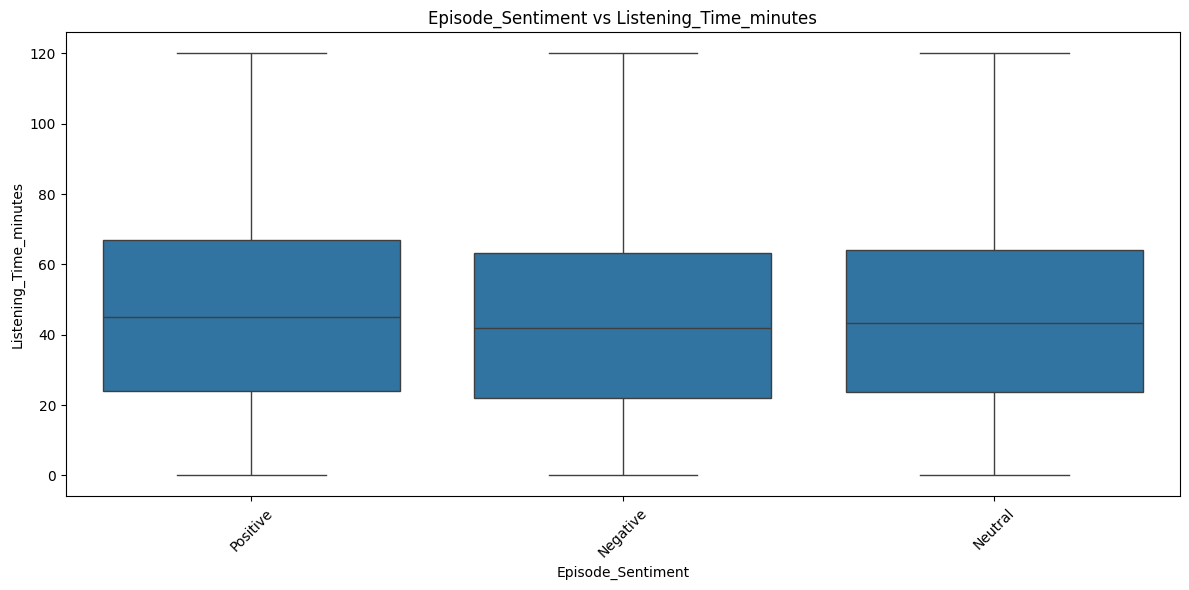

In [15]:
# Function for EDA visualizations
def plot_eda(df, target_col=None):
    """Generate exploratory data analysis plots"""
    # Missing values heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Missing values percentages
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
    plt.figure(figsize=(12, 6))
    missing_percent[missing_percent > 0].plot(kind='bar')
    plt.title('Percentage of Missing Values by Feature')
    plt.ylabel('Percentage')
    plt.tight_layout()
    plt.show()
    
    if target_col and target_col in df.columns:
        # Target distribution (for regression, use histogram)
        plt.figure(figsize=(10, 5))
        sns.histplot(df[target_col], bins=30, kde=True)
        plt.title(f'Distribution of {target_col}')
        plt.xlabel(target_col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
        
        # Correlation heatmap for numerical features
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        plt.figure(figsize=(12, 10))
        correlation = df[numerical_cols].corr()
        mask = np.triu(correlation)
        sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.show()
        
        # Scatter plots for numerical features against target
        for col in numerical_cols:
            if col != target_col:
                plt.figure(figsize=(12, 6))
                sns.scatterplot(x=df[col], y=df[target_col])
                plt.title(f'{col} vs {target_col}')
                plt.xlabel(col)
                plt.ylabel(target_col)
                plt.tight_layout()
                plt.show()

        # Feature relationships with target for categorical features
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != target_col and df[col].nunique() < 10]
        
        for col in categorical_cols[:3]:  # Limit to first 3 categorical features
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=col, y=target_col, data=df)
            plt.title(f'{col} vs {target_col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Run EDA on train data
plot_eda(train, 'Listening_Time_minutes')

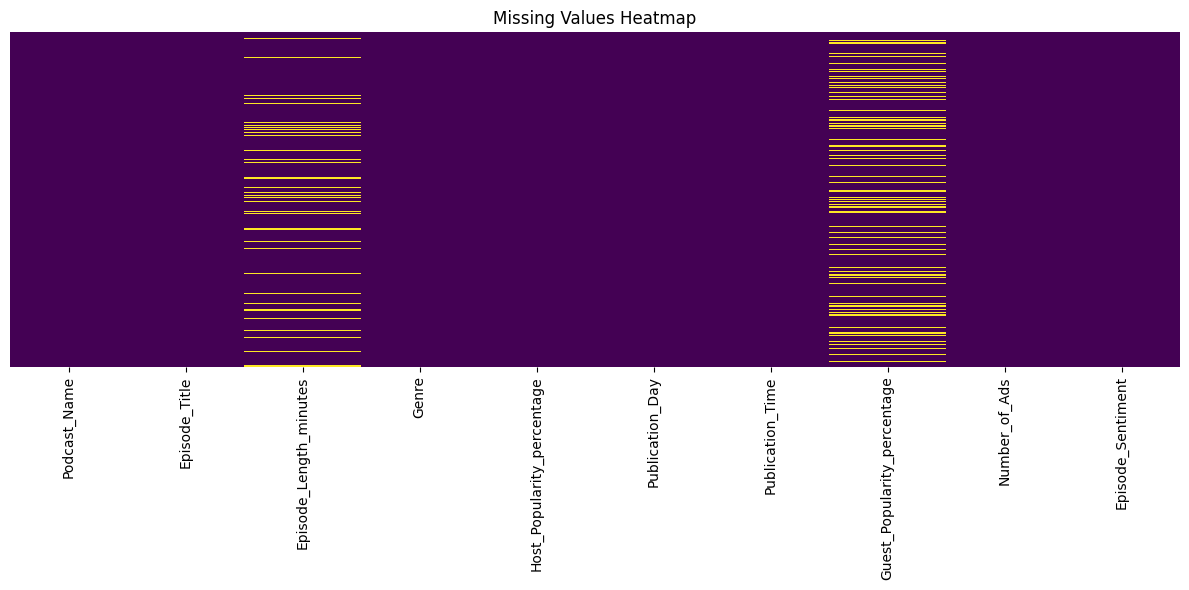

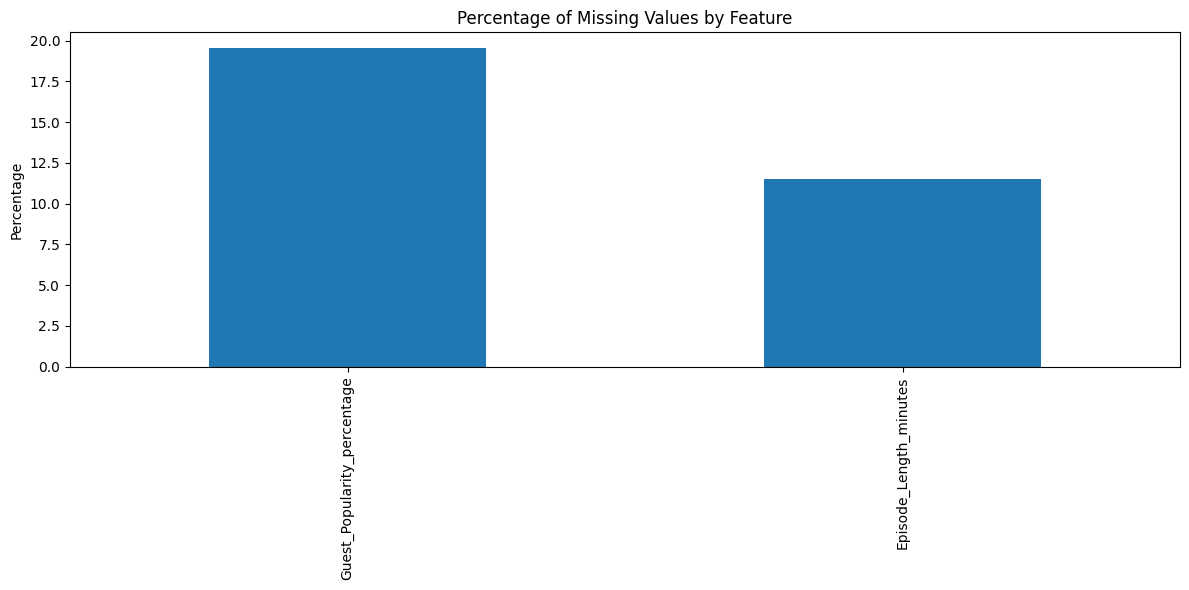

In [16]:
plot_eda(test)

In [17]:
(train.isnull().mean())*100

Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         11.612400
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    19.470667
Number_of_Ads                   0.000133
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [18]:
(test.isnull().mean())*100

Podcast_Name                    0.0000
Episode_Title                   0.0000
Episode_Length_minutes         11.4944
Genre                           0.0000
Host_Popularity_percentage      0.0000
Publication_Day                 0.0000
Publication_Time                0.0000
Guest_Popularity_percentage    19.5328
Number_of_Ads                   0.0000
Episode_Sentiment               0.0000
dtype: float64

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 62.9+ MB


In [20]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,64.504738,59.859901,52.236449,1.348855,45.437406
std,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.730000,39.410000,28.380000,0.000000,23.178350
50%,63.840000,60.050000,53.580000,1.000000,43.379460
75%,94.070000,79.530000,76.600000,2.000000,64.811580
max,325.240000,119.460000,119.910000,103.910000,119.970000


## Data PreProcessing

In [21]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [22]:
test.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [23]:
train.columns

Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre',
       'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time',
       'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment',
       'Listening_Time_minutes'],
      dtype='object')

## For Train Data

In [24]:
## getting all different type of feature
num_features = [feature for feature in train.columns if  train[feature].dtype != 'O']
print("Number of numerical features : ",len(num_features))
cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
print("Number of categorical features : ",len(cat_features))
discrete_features = [feature for feature in num_features if len(train[feature].unique()) <= 25]
print("Number of discrete features : ",len(discrete_features))
continuous_features  = [feature for feature in num_features if len(train[feature].unique()) > 25]
print("Number of continuous features :  ",len(continuous_features))

Number of numerical features :  5
Number of categorical features :  6
Number of discrete features :  1
Number of continuous features :   4


In [25]:
## check Missing Values 
### these are the features with nan value
features_with_nan = [features for features in train.columns if train[features].isnull().sum() >= 1]
for feature in features_with_nan:
    print(feature,np.round(train[feature].isnull().mean()*100,5), '% missing values')

Episode_Length_minutes 11.6124 % missing values
Guest_Popularity_percentage 19.47067 % missing values
Number_of_Ads 0.00013 % missing values


In [26]:
## statistics on numerical columns (Null cols)
train[features_with_nan].select_dtypes(exclude='object').describe()

,Episode_Length_minutes,Guest_Popularity_percentage,Number_of_Ads
count,662907.000000,603970.000000,749999.000000
mean,64.504738,52.236449,1.348855
std,32.969603,28.451241,1.151130
min,0.000000,0.000000,0.000000
25%,35.730000,28.380000,0.000000
50%,63.840000,53.580000,1.000000
75%,94.070000,76.600000,2.000000
max,325.240000,119.910000,103.910000


In [27]:
train['Podcast_Name'].value_counts()

Podcast_Name
Tech Talks             22847
Sports Weekly          20053
Funny Folks            19635
Tech Trends            19549
Fitness First          19488
Business Insights      19480
Style Guide            19364
Game Day               19272
Melody Mix             18889
Criminal Minds         17735
Finance Focus          17628
Detective Diaries      17452
Crime Chronicles       17374
Athlete's Arena        17327
Fashion Forward        17280
Tune Time              17254
Business Briefs        17012
Lifestyle Lounge       16661
True Crime Stories     16373
Sports Central         16191
Digital Digest         16171
Humor Hub              16144
Mystery Matters        16002
Comedy Corner          15927
Joke Junction          15074
Wellness Wave          15009
Sport Spot             14778
Gadget Geek            14770
Home & Living          14686
Laugh Line             14673
Life Lessons           14464
World Watch            14043
Sound Waves            13928
Global News            13649
M

In [28]:
train['Episode_Title'].value_counts()

Episode_Title
Episode 71    10515
Episode 62    10373
Episode 31    10292
Episode 61     9991
Episode 69     9864
              ...  
Episode 2      5134
Episode 25     5117
Episode 41     4965
Episode 37     4940
Episode 95     4838
Name: count, Length: 100, dtype: int64

In [29]:
train['Genre'].value_counts()

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

In [30]:
train['Publication_Day'].value_counts()

Publication_Day
Sunday       115946
Monday       111963
Friday       108237
Wednesday    107886
Thursday     104360
Saturday     103505
Tuesday       98103
Name: count, dtype: int64

In [31]:
train['Publication_Time'].value_counts()

Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
Name: count, dtype: int64

In [32]:
train['Episode_Sentiment'].value_counts()

Episode_Sentiment
Neutral     251291
Negative    250116
Positive    248593
Name: count, dtype: int64

In [33]:
cat_features

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

In [34]:
num_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Listening_Time_minutes']

In [35]:
(train.isnull().mean())*100

Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         11.612400
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    19.470667
Number_of_Ads                   0.000133
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [36]:
### Imputing Null Values
## for numerical values
# Episode Length minutes
train['Episode_Length_minutes'] = train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].median())
# Guest Popularity percentage
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(train['Guest_Popularity_percentage'].median())
# Number of ads
train['Number_of_Ads'] =  train['Number_of_Ads'].fillna(0)

In [37]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,63.84,True Crime,74.81,Thursday,Night,53.58,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [38]:
(train.isnull().mean())*100

Podcast_Name                   0.0
Episode_Title                  0.0
Episode_Length_minutes         0.0
Genre                          0.0
Host_Popularity_percentage     0.0
Publication_Day                0.0
Publication_Time               0.0
Guest_Popularity_percentage    0.0
Number_of_Ads                  0.0
Episode_Sentiment              0.0
Listening_Time_minutes         0.0
dtype: float64

## For Test Data

In [39]:
## getting all different type of feature
num_features_test = [feature for feature in test.columns if  test[feature].dtype != 'O']
print("Number of numerical features : ",len(num_features_test))
cat_features_test = [feature for feature in test.columns if test[feature].dtype == 'O']
print("Number of categorical features : ",len(cat_features_test))
discrete_features_test = [feature for feature in num_features_test if len(test[feature].unique()) <= 25]
print("Number of discrete features : ",len(discrete_features_test))
continuous_features_test  = [feature for feature in num_features_test if len(test[feature].unique()) > 25]
print("Number of continuous features :  ",len(continuous_features_test))

Number of numerical features :  4
Number of categorical features :  6
Number of discrete features :  1
Number of continuous features :   3


In [40]:
(test.isnull().mean())*100

Podcast_Name                    0.0000
Episode_Title                   0.0000
Episode_Length_minutes         11.4944
Genre                           0.0000
Host_Popularity_percentage      0.0000
Publication_Day                 0.0000
Publication_Time                0.0000
Guest_Popularity_percentage    19.5328
Number_of_Ads                   0.0000
Episode_Sentiment               0.0000
dtype: float64

In [41]:
test.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,4.192987e+02,59.716491,52.192796,1.355852
std,1.668545e+05,22.880028,28.445034,4.274399
min,2.470000e+00,2.490000,0.000000,0.000000
25%,3.578000e+01,39.250000,28.320000,0.000000
50%,6.397000e+01,59.900000,53.360000,1.000000
75%,9.415000e+01,79.390000,76.560000,2.000000
max,7.848626e+07,117.760000,116.820000,2063.000000


In [42]:
### Imputing Null Values
## for numerical values
# Episode Length minutes
test['Episode_Length_minutes'] = test['Episode_Length_minutes'].fillna(test['Episode_Length_minutes'].median())
# Guest Popularity percentage
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(test['Guest_Popularity_percentage'].median())


In [43]:
(test.isnull().mean())*100

Podcast_Name                   0.0
Episode_Title                  0.0
Episode_Length_minutes         0.0
Genre                          0.0
Host_Popularity_percentage     0.0
Publication_Day                0.0
Publication_Time               0.0
Guest_Popularity_percentage    0.0
Number_of_Ads                  0.0
Episode_Sentiment              0.0
dtype: float64

In [44]:
test.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,53.36,0.0,Neutral
2,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


## Label Encoding

In [45]:
## Independent features and  dependent features
x = train.drop(['Listening_Time_minutes'],axis=1)
y = train['Listening_Time_minutes']

In [46]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3  = LabelEncoder()
le4 = LabelEncoder()

In [47]:
x['Podcast_Name'] = le1.fit_transform(x['Podcast_Name'])

In [48]:
x['Episode_Title'] = le2.fit_transform(x['Episode_Title'])

In [49]:
x['Genre'] = le3.fit_transform(x['Genre'])

In [50]:
x['Publication_Day'] = le4.fit_transform(x['Publication_Day'])

## Feature Encoding  and Scaling
### One Hot Encoding for Columns which had lesser unique values and not ordinal 

In [51]:
## Creating Column Transformer with 3 types of transformer
num_features = ['Episode_Length_minutes','Host_Popularity_percentage','Guest_Popularity_percentage',
 'Number_of_Ads']
onehot_columns = ['Publication_Time','Episode_Sentiment']

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, onehot_columns),
        ("StandardScaler", numeric_transformer, num_features),
        
        
    ],remainder='passthrough'
    
)

In [52]:
x  = preprocessor.fit_transform(x)

In [53]:
pd.DataFrame(x).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,1.0,0.0,1.0,-0.018955,0.653611,0.042368,-1.171764,34.0,98.0,9.0,4.0
1,0.0,0.0,0.0,0.0,0.0,1.786382,0.309976,0.918347,0.565659,24.0,19.0,1.0,2.0
2,1.0,0.0,0.0,0.0,0.0,0.305593,0.442009,-1.704500,-1.171764,40.0,8.0,2.0,5.0
3,0.0,1.0,0.0,0.0,1.0,0.088475,-0.115415,1.026033,0.565659,10.0,40.0,8.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.486676,0.883576,0.242077,1.434371,31.0,85.0,3.0,1.0


In [54]:
## seperate dataset into train and test dataset 
x_train,x_cv,y_train,y_cv = train_test_split(x,y,test_size=0.25,random_state=42)

In [55]:
x_train.shape

(562500, 13)

In [56]:
x_cv.shape

(187500, 13)

In [57]:
## Create a function for Evaluation 
def evaluate_model(true,pred):
    mae = mean_absolute_error(true,pred)
    mse = mean_squared_error(true,pred)
    rmse = np.sqrt(mse)
    score = r2_score(true,pred)
    return mae , mse ,rmse ,score

In [58]:
## Beginning  Model training
models = {
    "Random Forest regresssor": RandomForestRegressor(),
    "AdaBoost Regressor" : AdaBoostRegressor(),
    "GradientBoost Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "LightGBM Regression": LGBMRegressor(force_col_wise=True),
}

In [59]:
train_scores = {}
test_scores = {}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train,y_train) # Train model first dataset
    # model.fit(x1_train,y1_train) # Train model second dataset

    # Make Prediction
    y_train_pred = model.predict(x_train)
    y_cv_pred = model.predict(x_cv)   # Evaluate Train and Test dataset 
    model_train_mae , model_train_mse ,model_train_rmse ,model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_cv_mae , model_cv_mse ,model_cv_rmse ,model_cv_r2 =  evaluate_model(y_cv,y_cv_pred)

    print(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    train_scores[list(models.keys())[i]] =  model_train_r2

    print('-'*35)

    print('Model performance for Test set')
    print("- Mean Squared Error: {:.4f}".format(model_cv_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_cv_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_cv_mae))
    print("- R2 Score: {:.4f}".format(model_cv_r2))
    test_scores[list(models.keys())[i]] = model_cv_r2
    
    print('='*35)
    print('\n')

Random Forest regresssor
Model performance for Training set
- Mean Squared Error: 22.7539
- Root Mean Squared Error: 4.7701
- Mean Absolute Error: 3.3669
- R2 Score: 0.9691
-----------------------------------
Model performance for Test set
- Mean Squared Error: 160.9392
- Root Mean Squared Error: 12.6862
- Mean Absolute Error: 9.0409
- R2 Score: 0.7811


AdaBoost Regressor
Model performance for Training set
- Mean Squared Error: 186.0387
- Root Mean Squared Error: 13.6396
- Mean Absolute Error: 10.0959
- R2 Score: 0.7476
-----------------------------------
Model performance for Test set
- Mean Squared Error: 184.6485
- Root Mean Squared Error: 13.5885
- Mean Absolute Error: 10.0555
- R2 Score: 0.7488


GradientBoost Regressor
Model performance for Training set
- Mean Squared Error: 173.4682
- Root Mean Squared Error: 13.1707
- Mean Absolute Error: 9.6080
- R2 Score: 0.7646
-----------------------------------
Model performance for Test set
- Mean Squared Error: 172.5956
- Root Mean Squa

In [60]:
#Initialize few parameter for Hyperparamter tuning

rf_params = {"max_depth": [ele for ele in range(6,10,2)],
             "max_features": [5, 7, 8],
             "min_samples_split": [ele for ele in range(2,8,2)],
             'criterion':['squared_error'],
             "n_estimators": [ele for ele in range(200,500,50)]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [ele for ele in range(6,10,2)],
                  "n_estimators": [ele for ele in range(200,500,50)],
                  "colsample_bytree": [round(i, 1) for i in np.arange(0.1, 0.6, 0.1)]}

ada_params = {
    "n_estimators": [50,60,70,80],
    'loss':['linear', 'square', 'exponential']
}

gradient_params={"loss": ['squared_error','huber','absolute_error'],
             "criterion": ['friedman_mse','squared_error'],
             "min_samples_split": [2, 8, 15, 12],
             "n_estimators": [100, 200, 500],
              "max_depth": [5, 8,  None, 10],
            }
light_gbm_params = {
    "n_estimators": [ele for ele in range(200,500,50)],
    "colsample_bytree":[round(i, 1) for i in np.arange(0.1, 0.6, 0.1)],
    
}


In [61]:
rf_params

{'max_depth': [6, 8],
 'max_features': [5, 7, 8],
 'min_samples_split': [2, 4, 6],
 'criterion': ['squared_error'],
 'n_estimators': [200, 250, 300, 350, 400, 450]}

In [62]:
## Models list for HyperParameter Tuning 
randomcv_models = [
    ("RF", RandomForestRegressor(),rf_params),
    ("XG",XGBRegressor(),xgboost_params),
    ("ADA",AdaBoostRegressor(),ada_params),
    ("GRA",GradientBoostingRegressor(),gradient_params),
    ("LIGHT",LGBMRegressor(force_col_wise=True),light_gbm_params)
]

In [63]:
randomcv_models

[('RF',
  RandomForestRegressor(),
  {'max_depth': [6, 8],
   'max_features': [5, 7, 8],
   'min_samples_split': [2, 4, 6],
   'criterion': ['squared_error'],
   'n_estimators': [200, 250, 300, 350, 400, 450]}),
 ('XG',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
  {'lea

In [ ]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(x_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=squared_error, max_depth=6, max_features=5, min_samples_split=6, n_estimators=250; total time= 2.0min
[CV] END criterion=squared_error, max_depth=6, max_features=5, min_samples_split=6, n_estimators=250; total time= 2.0min
[CV] END criterion=squared_error, max_depth=6, max_features=5, min_samples_split=6, n_estimators=250; total time= 2.0min
[CV] END criterion=squared_error, max_depth=6, max_features=8, min_samples_split=4, n_estimators=200; total time= 2.4min
[CV] END criterion=squared_error, max_depth=6, max_features=8, min_samples_split=4, n_estimators=200; total time= 2.4min
[CV] END criterion=squared_error, max_depth=6, max_features=8, min_samples_split=4, n_estimators=200; total time= 2.4min
[CV] END criterion=squared_error, max_depth=6, max_features=7, min_samples_split=2, n_estimators=250; total time= 2.6min
[CV] END criterion=squared_error, max_depth=6, max_features=7, min_samples_split=2, n_estima

In [ ]:
model_param 

In [ ]:
## Retraining the models with best parameters
### creating variables for parameter of the models 

#1. for RANDOM FOREST
estimator = model_param['RF']['n_estimators']
min_sample_split = model_param['RF']['min_samples_split']
max_feature = model_param['RF']['max_features']
max_depths = model_param['RF']['max_depth']
#2. for XGBOOST
estimate = model_param['XGB']['n_estimators']
learning_rate_xgb = model_param['XGB']['learning_rate']
max_deep = model_param['XGB']['max_depth']
colsample_bytree_xgb = model_param['XGB']['colsample_bytree']
#3 for lightgbm
estimate_light = model_param['lightGBM']['n_estimators']
learning_rate_reg = model_param['lightGBM']['learning_rate ']
max_depth_light = model_param['lightGBM']['max_depth']
colsample_light = model_param['lightGBM']['colsample_bytree']


## creating training score and testing score dictionaries
train_best_score ,test_best_score = {} , {}
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=estimator,min_samples_split=min_sample_split,
                                                     max_features=max_feature,max_depth=max_depths, 
                                                     n_jobs=-1),
     "XGBBoost Regressor": XGBRegressor(n_estimators=estimate,learning_rate=learning_rate_xgb,
                                                     colsample_bytree = colsample_bytree_xgb,
                                       max_depth=max_deep,n_jobs=-1),
    "LightGBM Regressor":LGBMRegressor(n_estimators=estimate_light,learning_rate=learning_rate_reg,max_depth=max_depth_light,
                                       colsample_bytree=colsample_light,n_jobs = -1)
                                                          
                                                          
    
}
accuracy_score_train,accuracy_score_test, = {},{}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

   # Evaluate Train and Test dataset 
    model_train_mae , model_train_mse ,model_train_rmse ,model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_mse ,model_test_rmse ,model_test_r2 =  evaluate_model(y_test,y_test_pred)

    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    train_best_score[model] = model_train_rmse
    accuracy_score_train[model] = model_train_r2
    

    print('-'*35)

    print('Model performance for Test set')
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    test_best_score[model] = model_test_rmse
    accuracy_score_test[model] = model_test_r2
    
    print('='*35)
    print('\n')